In [8]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from mpmath import hyp2f1, factorial, gamma
import functools
fsc = constants.alpha   
aB_in_cm = constants.value('Bohr radius') * 1e2
Ry_in_erg = constants.value('Rydberg constant times hc in J') * 1.e7 #in ergs
kb = constants.k * 1e7
h = constants.value('Planck constant') * 1e7 #in ergs s
c = constants.c * 1.e2 # in cm/s
e_e = 4.80320451e-10 #in statcoulomb
m_e = constants.electron_mass * 1e3 # in g

In [2]:
def I(eta_i, eta_f, k_i, k_f, l):
    """something dumb (radial-dipole integral)
    
    Arguments:
    eta_i  : modified quantum number associated with initial energy
    eta_f  : modified quantum number associated with final energy
    k_i    : wavenumber associated with initial energy
    k_f    : wavenumber associated with final energy
    l      : azimuthal quantum number
    
    Returns:
    I_l    : some number.
    """
    temp1 = 1/4*(4.* k_i * k_f / (k_i - k_f)**2)**(l+1) 
    temp2 = np.exp(np.pi/2*abs(eta_i - eta_f))
    temp3 = abs(gamma(l+1+1j*eta_i) * gamma(l+1+1j*eta_f)) / gamma(2.*l + 2)
    return temp1 * temp2 * temp3 *G(eta_i, eta_f, k_i, k_f, l)

def G(eta_i, eta_f, k_i, k_f, l):
    """something dumb helper"""
    temp1 = abs((k_f - k_i) / (k_f + k_i))**(1j*eta_i + 1j*eta_f)
    temp2 = hyp2f1(l+1-1j*eta_f, 
                   l+1-1j*eta_i, 
                   2.*l+2, 
                   -4.*k_i*k_f/(k_i-k_f)**2)

    return (temp1 * temp2).real

In [3]:
def gaunt_free_free(Z, beta, E):
    """calculate the Gaunt factor for free-free emission
    
    Arguments:
    Z    : ion charge, int
    beta : velocity of incident electron in units of c, float or array
    E    : energy of photon in units of Ha, float or array
    
    Returns:
    g_ff : gaunt factor for free-free emission"""
    
    eta_i = Z * fsc / beta
    k_i = Z / eta_i / aB_in_cm
    eta_f = Z * fsc / (beta**2 + 2*E*fsc**2)**.5
    k_f = Z / eta_f / aB_in_cm

    I0 = I(eta_i, eta_f, k_i, k_f, 0)
    I1 = I(eta_i, eta_f, k_i, k_f, 1)
    
    out = 2*3**.5/np.pi/eta_i/eta_f * I0
    out *=((eta_i**2 + eta_f**2 + 2*eta_i**2*eta_f**2)*I0 - 2 * eta_i * eta_f * (1 + eta_i**2)**.5*(1+eta_f**2)**.5*I1)

    return out.real

In [4]:
def free_free_emission_spectrum(Z, hnu, E):
    """calculate free-free spectrum
    
    Arguments:
    Z    : ion charge, int
    hnu  : energy of emitted photon, in Ha
    E    : electron final energy, in Ha"""
    if hnu >= E:
        return 0.
    g_ff = gaunt_free_free(Z, fsc * (2*(E - hnu))**.5, hnu)
    return 64 * np.pi**2 / 3 / 3**.5 * Z**2 * fsc**3 / (2*E)**.5 * g_ff

The free-free emission per unit volume of a thermal gas is obtained averaging over a Maxwellian distribution, $f(E) \propto \sqrt{E} exp(-E/T)$

In [5]:
def free_free_thermal_spectrum(Z, T, E):
    """calculate free-free spectrum
    from an ensemble of electrons following a Maxwellian
    
    Arguments:
    Z    : ion charge, int
    T    : temperature of electrons, in Ha
    E    : energies of emitted photons, in Ha
    """
    out = np.zeros_like(E)
    for i, hnu in enumerate(E):
        out[i] = scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T) * free_free_emission_spectrum(Z, hnu, x), hnu, np.inf)[0]
        out[i] /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x / T), 0, np.inf)[0]
    return out

Emissivity $\epsilon_{\nu}$ of free-free emission from an ensemble of electrons therefore is proportional to the velocitiy weighted Gaunt factor.
$$\epsilon_{\nu,ff} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 \sqrt{3} m^2 c^3}N_i N_e \frac{\int_{h\nu}^{\infty}g(E, \nu) e^{-E / k T} dE}{\int_{0}^{\infty}\sqrt{E} e^{-E / k T} dE} = \frac{1}{2\pi}\frac{2^5 Z^2 e^6}{3 m c^3}N_i N_e \bigg(\frac{2\pi}{3 k T m}\bigg)^{1/2} e^{-h \nu / k T} \bar{g}_{ff}$$

I am putting emissivity in cgs units.

In [22]:
def emissivity_free_free(Z, Ni, Ne, T, nu):
    """calculate emissivity of free free emission
    
    Arguments:
    Z    : ion charge, int
    Ni   : ion density, in cm^-3
    Ne   : electron density, in cm^-3
    T    : temperature of electrons, in K
    nu   : frequency, in Hz
    """
    T_Ha = T * 3.16680853419133e-6
    hnu_Ha = nu * 1.519828500715e-16
    
    term = scipy.integrate.quad(lambda x:np.exp(-x/T_Ha) * gaunt_free_free(Z, fsc*(2*(x-hnu_Ha))**.5, hnu_Ha), hnu_Ha, np.inf)[0]
    term /= scipy.integrate.quad(lambda x: x**.5 * np.exp(-x/T_Ha), 0, np.inf)[0]
    # the exponential is folded into the numerator
    
    prefactor = 2**5 * np.pi * Z**2 * e_e**6 / 3 / m_e / c**3
    temp2 = (2 * np.pi / 3 /kb/m_e/T)**.5
    return Ni*Ne*prefactor*temp2*term

In [23]:
test = []
for nu in np.logspace(np.log10(3e13),np.log10(3e15),20):
    test.append(nu * emissivity_free_free(1, 1, 1, 10000, nu))

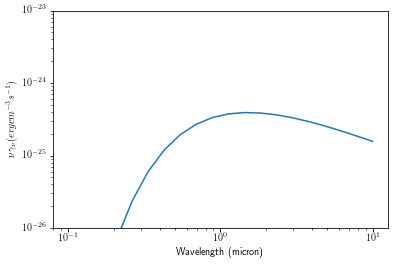

In [24]:
plt.loglog(3e14/np.logspace(np.log10(3e13),np.log10(3e15),20), np.array(test))
plt.ylim(1e-26,1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [13]:
def G_l(l, m, eta, rho):
    """G matrix element"""
    gl = 0
    for i in range(2*m + 1):
        gl += b_s(i, l, m, eta, rho) * rho**i
        
    return gl
@functools.lru_cache(maxsize=128)
def b_s(s, l, m, eta, rho):
    """polynomial solution to matrix element G_l"""
    if s == 0:
        return 1
    if s == 1:
        return 2 * m * eta / l
    
    bsminus1 = b_s(s-1, l, m, eta, rho)
    bsminus2 = b_s(s-2, l, m, eta, rho)
    bs = -(1/(s*(s + 2*l-1))) * (4*eta * (s - 1 - m)*bsminus1 + (2 * m + 2. - s)* (2*m + 2*l + 1 - s) * bsminus2)
    return bs

In [14]:
def sigma_minus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l-1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    nu = E / h
    if l == 0:
        return 0

    rho = eta / n
    GlA = G_l(l, -(l+1-n), eta, rho)
    GlB = G_l(l, -(l-1-n), eta, rho)

    prefactor = 2**(4*l)/3*np.pi * e_e**2/m_e/c / nu
    
    A = 1
    for l_i in range(1, l):
        A*= (l_i**2 + eta**2)
    B = l**2 * factorial(n+l) / factorial(2*l +1) /factorial(2*l-1)/factorial(n-l-1)
    C = np.exp(-4*eta * np.arctan2(1,rho)) / (1-np.exp(-2*np.pi*eta)) 
    D = rho**(2*l+2)/(1+rho**2)**(2*n-2)
    E = (GlA - (1+rho**2)**(-2)*GlB)**2
    return prefactor*A *B*C*D*E

def sigma_plus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l+1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    nu = E / h
    GlA = G_l(l+1, -(l+1-n), eta, rho)
    GlB = G_l(l+1, -(l-n), eta, rho)

    prefactor = 2**(4*l + 6)/3*np.pi * e_e**2/m_e/c / nu
    
    A = 1
    for l_i in range(l + 1):
        A*= ((l_i+1)**2 + eta**2)
    B = (l+1)**2 * factorial(n+l) / (2*l+1)/factorial(2*l +1) /factorial(2*l+2)/factorial(n-l-1)/((l+1)**2+eta**2)**2
    
    C = np.exp(-4*eta * np.arctan2(1,rho)) / (1-np.exp(-2*np.pi*eta)) 
    D = rho**(2*l+4)*eta**2/(1+rho**2)**(2*n)
    E = ((l+1-n)*GlA + (l+1+n)/(1+rho**2)*GlB)**2
    return prefactor*A *B*C*D*E    

In [15]:
@functools.lru_cache(maxsize=1024)
def sigma_bf_nl(n, l, nu, Z):
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    return sigma_plus(n, l, h*nu, Z) + sigma_minus(n, l, h*nu, Z)
@functools.lru_cache(maxsize=1024)
def sigma_bf_n(n, Z, nu):
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    gbf = 0
    for l in range(n):
        gbf += (2*l + 1) * sigma_bf_nl(n, l, nu, Z)

    return gbf / n**2

In [16]:
def gamma_fb_n(n, Z, nu, T):
    A = (2/np.pi)**.5
    B = np.exp(Z**2 * Ry_in_erg/n**2 / kb/T)/c**2/(m_e * kb*T)**(3/2)
    C = 2 * n**2 * h * (h*nu)**3 
    D = sigma_bf_n(n, Z, nu) 
    E = np.exp(-h*nu/kb/T)

    return A*B*C*D*E

In [17]:
def j_nu_fb(n, Z, nu, T, n_i, n_e):
    #return 1/4/np.pi * n_i * n_e * sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])
    return sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])

In [18]:
test1 = []
for nu in np.logspace(np.log10(3e13),np.log10(3e15),200):
    test1.append(nu * j_nu_fb(20, 1, nu, 10000,1e4,1e4))

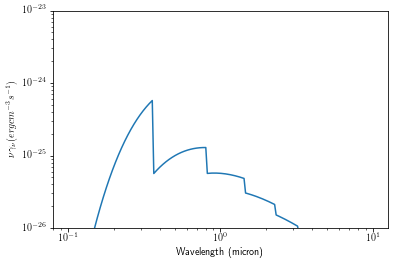

In [19]:
plt.loglog(3e14/np.logspace(np.log10(3e13),np.log10(3e15),200), np.array(test1))
plt.ylim(1e-26,1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')

In [34]:
test2 = []
for nu in np.logspace(np.log10(3e13),np.log10(3e15),200):
    test2.append(nu * (1/2/np.pi*emissivity_free_free(1, 1, 1, 10000, nu) + 3*j_nu_fb(20, 1, nu, 10000,1e4,1e4)))

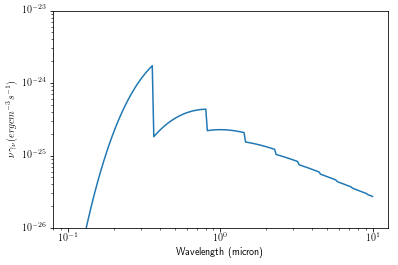

In [35]:
plt.loglog(3e14/np.logspace(np.log10(3e13),np.log10(3e15),200), np.array(test2))
plt.ylim(1e-26,1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')